[*********************100%***********************]  1 of 1 completed


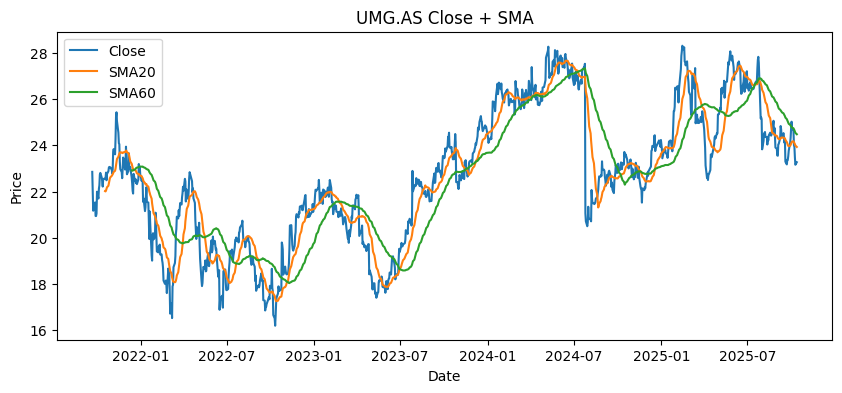

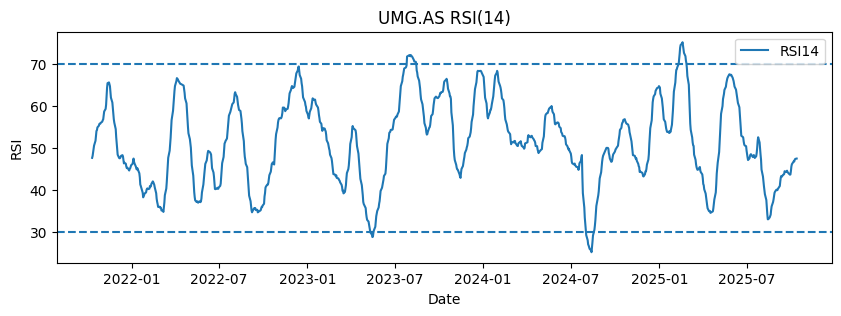

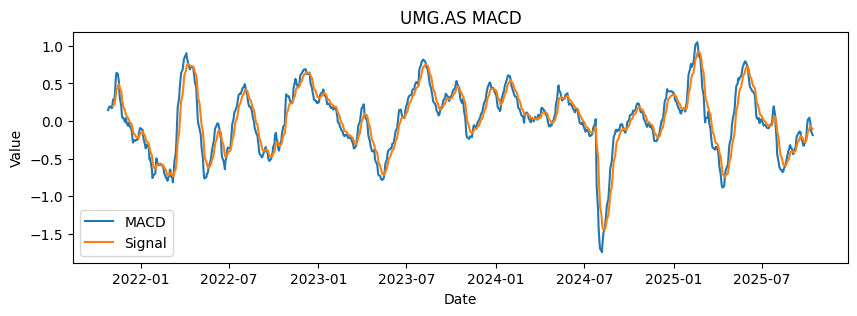

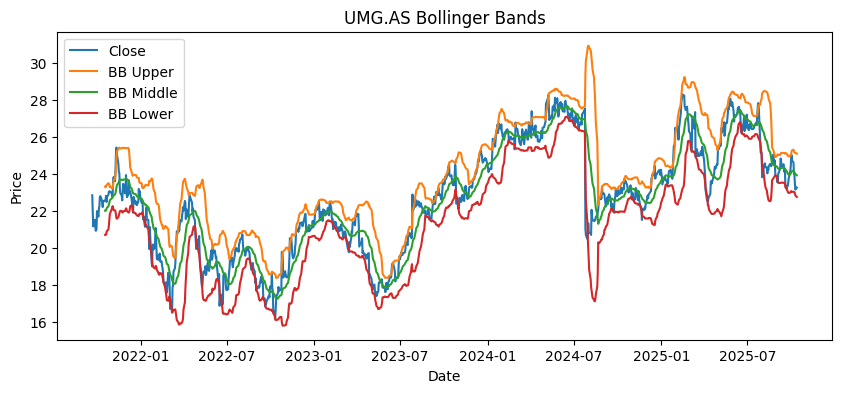

/var/folders/n3/kjpx2ctx5mb_d1p6ntdrl7hr0000gn/T/ipykernel_56736/425865311.py:98: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  position = sig.replace(to_replace=0, method="ffill").clip(-1, 1)


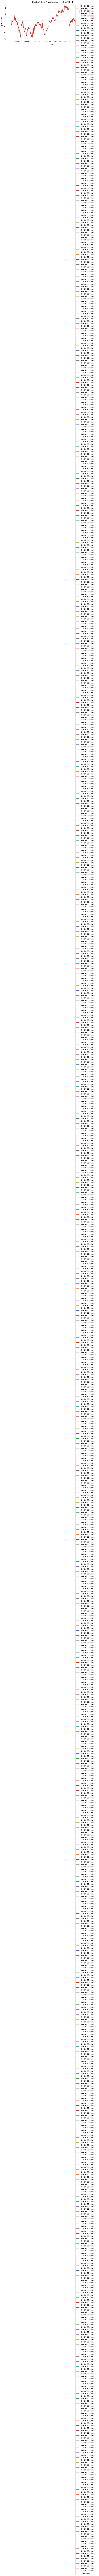

전략 누적수익률: UMG.AS                 0.0
2021-09-21 00:00:00    0.0
2021-09-22 00:00:00    0.0
2021-09-23 00:00:00    0.0
2021-09-24 00:00:00    0.0
                      ... 
2025-10-07 00:00:00    0.0
2025-10-08 00:00:00    0.0
2025-10-09 00:00:00    0.0
2025-10-10 00:00:00    0.0
2025-10-13 00:00:00    0.0
Name: 2025-10-13 00:00:00, Length: 1043, dtype: float64
바이앤홀드: Ticker
UMG.AS    0.0183
Name: 2025-10-13 00:00:00, dtype: float64


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# ===== 1) 데이터 =====
ticker = "UMG.AS"
df = yf.download(ticker, period="5y", auto_adjust=True)

# ===== 2) 함수들 =====
def SMA(series: pd.Series, n: int) -> pd.Series:
    return series.rolling(window=n, min_periods=n).mean()

def EMA(series: pd.Series, n: int) -> pd.Series:
    return series.ewm(span=n, adjust=False, min_periods=n).mean()

def RSI(series: pd.Series, n: int = 14) -> pd.Series:
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(n, min_periods=n).mean().ewm(alpha=1/n, adjust=False).mean()
    avg_loss = loss.rolling(n, min_periods=n).mean().ewm(alpha=1/n, adjust=False).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def MACD(series: pd.Series, fast=12, slow=26, signal=9):
    ema_fast = EMA(series, fast)
    ema_slow = EMA(series, slow)
    macd = ema_fast - ema_slow
    signal_line = EMA(macd, signal)
    hist = macd - signal_line
    return macd, signal_line, hist

def bollinger_bands(series: pd.Series, n=20, k=2.0):
    mid = SMA(series, n)
    std = series.rolling(n, min_periods=n).std()
    upper = mid + k * std
    lower = mid - k * std
    return upper, mid, lower

def stochastic_oscillator(df: pd.DataFrame, n=14, d=3):
    low_min = df["Low"].rolling(window=n, min_periods=n).min()
    high_max = df["High"].rolling(window=n, min_periods=n).max()
    k = (df["Close"] - low_min) / (high_max - low_min) * 100
    d_line = k.rolling(window=d, min_periods=d).mean()
    return k, d_line

def ATR(df: pd.DataFrame, n=14) -> pd.Series:
    prev_close = df["Close"].shift(1)
    tr = pd.concat([
        df["High"] - df["Low"],
        (df["High"] - prev_close).abs(),
        (df["Low"] - prev_close).abs()
    ], axis=1).max(axis=1)
    return tr.rolling(window=n, min_periods=n).mean()

# ===== 3) 지표 계산 =====
df["SMA20"], df["SMA60"] = SMA(df["Close"], 20), SMA(df["Close"], 60)
df["EMA20"], df["EMA60"] = EMA(df["Close"], 20), EMA(df["Close"], 60)
df["RSI14"] = RSI(df["Close"], 14)
(df["MACD"], df["MACDsig"], df["MACDhist"]) = MACD(df["Close"], 12, 26, 9)
(df["BBU"], df["BBM"], df["BBL"]) = bollinger_bands(df["Close"], 20, 2.0)
(df["%K"], df["%D"]) = stochastic_oscillator(df, 14, 3)
df["ATR14"] = ATR(df, 14)

# ===== 4) 시각화 예시(한 그래프당 한 지표) =====
plt.figure(figsize=(10,4))
plt.plot(df.index, df["Close"], label="Close")
plt.plot(df.index, df["SMA20"], label="SMA20")
plt.plot(df.index, df["SMA60"], label="SMA60")
plt.legend(); plt.title(f"{ticker} Close + SMA"); plt.xlabel("Date"); plt.ylabel("Price")
plt.show()

plt.figure(figsize=(10,3))
plt.plot(df.index, df["RSI14"], label="RSI14")
plt.axhline(70, linestyle="--"); plt.axhline(30, linestyle="--")
plt.legend(); plt.title(f"{ticker} RSI(14)"); plt.xlabel("Date"); plt.ylabel("RSI")
plt.show()

plt.figure(figsize=(10,3))
plt.plot(df.index, df["MACD"], label="MACD")
plt.plot(df.index, df["MACDsig"], label="Signal")
plt.legend(); plt.title(f"{ticker} MACD"); plt.xlabel("Date"); plt.ylabel("Value")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df.index, df["Close"], label="Close")
plt.plot(df.index, df["BBU"], label="BB Upper")
plt.plot(df.index, df["BBM"], label="BB Middle")
plt.plot(df.index, df["BBL"], label="BB Lower")
plt.legend(); plt.title(f"{ticker} Bollinger Bands"); plt.xlabel("Date"); plt.ylabel("Price")
plt.show()

# ===== 5) 간단 전략: SMA20-60 크로스 =====
sig = pd.Series(0, index=df.index)
sig[(df["SMA20"].shift(1) < df["SMA60"].shift(1)) & (df["SMA20"] >= df["SMA60"]) ] = 1
sig[(df["SMA20"].shift(1) > df["SMA60"].shift(1)) & (df["SMA20"] <= df["SMA60"]) ] = -1
position = sig.replace(to_replace=0, method="ffill").clip(-1, 1)
ret = df["Close"].pct_change()
strat_ret = position.shift(1) * ret
cum_eq = (1 + strat_ret.fillna(0)).cumprod()
buyhold = (1 + ret.fillna(0)).cumprod()

plt.figure(figsize=(10,4))
plt.plot(cum_eq.index, cum_eq, label="SMA20-60 Strategy")
plt.plot(buyhold.index, buyhold, label="Buy & Hold")
plt.legend(); plt.title(f"{ticker} SMA Cross Strategy vs Buy&Hold"); plt.xlabel("Date"); plt.ylabel("Equity Curve")
plt.show()

print("전략 누적수익률:", round(cum_eq.iloc[-1]-1, 4))
print("바이앤홀드:", round(buyhold.iloc[-1]-1, 4))
